In [327]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [328]:
import torch
from torch import nn
import torchvision
from torchvision.transforms import v2
from torchvision.models import *

torch.manual_seed(0)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cuda"
print(f"Using {device} device")

k = 47

model = get_model("efficientnet_v2_s", num_classes=k, dropout=.2)
model.features[0][0] = nn.Conv2d(1, 24, 3, 2, 1, bias=False)
model.to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params:,}")
# print(model)
model.load_state_dict(torch.load("./models/ip88")["model"])

Using cuda device
Number of parameters: 20,237,263


<All keys matched successfully>

In [329]:
emnist = {}

with open("./data/EMNIST/emnist_balanced_mapping.txt") as f:
    f = f.read()
    for line in f.split("\n"):
        line = line.split()
        emnist[int(line[0])] = int(line[1])    

def emnist_to_char(label):
    return chr(emnist[label])

In [330]:
import matplotlib.pyplot as plt
import math
from PIL import Image

In [331]:
def predict(file, model):
    transform = v2.Compose([
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True)
    ])
    transform2 = v2.Compose([
        lambda img: v2.functional.hflip(img),
        lambda img: v2.functional.rotate(img, 90),
    ])
    with Image.open(file) as image:
        img_tensor = transform(image)
        plt.subplot(2, 2, 1)
        plt.imshow(image, cmap="gray")
        plt.axis("off")
    img_tensor, _ = torch.max(img_tensor, dim=0, keepdim=True)
    # img_tensor = img_tensor / torch.max(img_tensor).item()
    plt.subplot(2, 2, 2)
    plt.imshow(img_tensor.squeeze(), cmap="gray")
    plt.axis("off")
    img_tensor = transform2(img_tensor).unsqueeze(0).to(device)
    plt.subplot(2, 2, 3)
    plt.imshow(img_tensor.squeeze().to("cpu"), cmap="gray")
    plt.show()
    
    model.eval()
    with torch.no_grad():
        logits = model(img_tensor)[0, :]
        logits = torch.softmax(logits, 0, None)
        topk = 3
        probs, ys = torch.topk(logits, topk)
        probs = probs
        ys = ys
        for i in range(topk):
            print(f"{emnist_to_char(ys[i].item())}: {probs[i].item():.4f}")


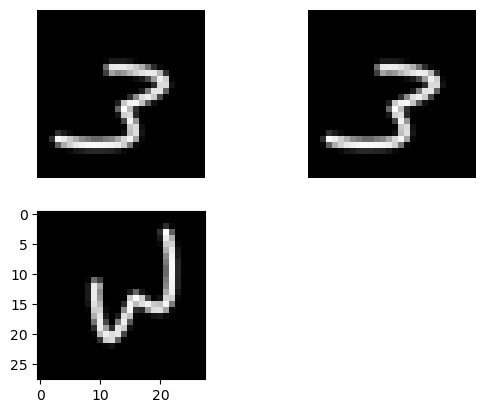

3: 0.9283
J: 0.0579
Z: 0.0046


In [332]:
predict("input.jpg", model)